# Simple presidential poll aggregator & election forecaster

A basic model for aggregating presidential polls and forecasting the 2020 presidential election by simulation. This model is over-simplified by design to illustrate the core features of a simulation-based forecasting model, and eliminate as much complexity -- and analyst input -- as possible. The model relies on polls only. It is little more than a poll aggregator with some options for expressing uncertainty in the polls.

The model produces three sets of estimates:

1. Simulated distributions of state popular vote outcomes that are consistent with the recent polling data
1. A simulated distribution of electoral vote outcomes that are consistent with the recent polling data
1. Simulated probabilities of Biden/Trump winning each state and the electoral vote

The algorithm:

1. Get state and national level polling data. Convert head-to-head poll results to their major-party vote shares. This excludes third party candidates and assumes undecideds "break" in proportion to the poll results. A poll showing Biden 45%-Trump 40% is treated as Biden 45/85 = 53% and Trump 40/85 = 47%.
1. If a state has been polled in the past two months, use the average of the state's polls as our best guess about the election outcome. There are no adjustments for house effects, mode effects, historical factors, "reversion" to a closer outcome by Election Day, etc. Polls are treated has having "happened" on the last day they were conducting interviews.
1. If a state has **not** been polled in the past two months, use as our best guess about the election outcome the state's 2016 election result plus the national shift to Biden based on national polls in 2020 (uniform swing).
1. Assume that the state vote estimates have an uncertainty range of plus-minus 10% regardless of how much polling has happened in the state. This is based on research in [this paper](https://votamatic.org/wp-content/uploads/2015/08/2015LauderdaleLinzerIJF.pdf). It can be adjusted with the "state_uncertainty_sd" parameter.
1. Assume that all of the states could have an additional national-level "correlated" error due to all polling being systematically biased by a certain amount. This is a national bias, not regional, clustered, etc. If the state polls are unbiased, on average, then the national error is zero. Assume the national bias will probably not exceed 6% in either direction. This can be adjusted with the "national_uncertainty_sd" parameter.
1. Simulate one national election:
  1. Sample an election result (Biden vote share) for each state from a normal distribution, with mean equal to the state's vote estimate, and standard deviation of 5%, then add a constant national error to every state with mean 0 and standard deviation of 3% in each simulation.
  1. The candidate who gets over 50% of the major-party vote in a state wins all of that state's electoral votes. (No adjustment for Maine/Nebraska.)
  1. The candidate who wins 270 electoral votes wins the election.
1. Repeat the simulation 10,000 times to get the chance that Biden/Trump will win the election.

Data source: The Economist https://projects.economist.com/us-2020-forecast/president

Drew Linzer \
https://twitter.com/drewlinzer

August 10, 2020

In [1]:
%pylab inline

import pandas as pd
from pandas import DataFrame, Series
from pandas.tseries.offsets import DateOffset
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Compute COVID Uncertainty

In [3]:
df = pd.read_csv('united_states_covid19_cases_and_deaths_by_state - united_states_covid19_cases_and_deaths_by_state.csv')

df = df[["State/Territory","Case Rate per 100000 in Last 7 Days"]]

state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

territories = [state for state in df["State/Territory"].unique() if state not in state_names]

df = df[~df["State/Territory"].isin(territories)]

df = df.reset_index(drop=True)

arr = (df["Case Rate per 100000 in Last 7 Days"] - df["Case Rate per 100000 in Last 7 Days"].mean())/df["Case Rate per 100000 in Last 7 Days"].std(ddof=0)

arr += 1
for x in range(0,50):
    if arr[x] < 1:
        arr[x] = 1
    elif arr[x] > 2:
        arr[x] = 2
df['Adjusted Z-Score'] = arr

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
"HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
"NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df["State/Territory"] = states
df = df[["State/Territory", "Adjusted Z-Score"]]
zscore = df.set_index("State/Territory")

In [4]:
zscore

,Adjusted Z-Score
State/Territory,
AL,1.830273
AK,1.185144
AZ,1.080415
AR,1.000000
CA,1.000000
CO,1.000000
CT,1.000000
DC,1.000000
DE,1.000000


## Load polling data from The Economist archive

- Discard polls older than two months
- Convert Biden and Trump to major-party vote share

In [5]:
polls = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ56fySJKLL18Lipu1_i3ID9JE06voJEz2EXm6JW4Vh11zmndyTwejMavuNntzIWLY0RyhA1UsVEen0/pub?gid=0&single=true&output=csv')

In [6]:
polls.head()

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes
0,TX,CES,NaN,9/29/2020,10/27/2020,11/1/2020 18:24:00,2947,lv,Online,47,49,-2,NaN,NaN,https://bfschaffner.shinyapps.io/ces_swing/,True,NaN
1,PA,CES,NaN,9/29/2020,10/27/2020,11/1/2020 18:24:00,2703,lv,Online,52,44,8,NaN,NaN,https://bfschaffner.shinyapps.io/ces_swing/,True,NaN
2,NC,CES,NaN,9/29/2020,10/27/2020,11/1/2020 18:24:00,1627,lv,Online,49,45,4,NaN,NaN,https://bfschaffner.shinyapps.io/ces_swing/,True,NaN
3,GA,CES,NaN,9/29/2020,10/27/2020,11/1/2020 18:24:00,1456,lv,Online,48,47,1,NaN,NaN,https://bfschaffner.shinyapps.io/ces_swing/,True,NaN
4,FL,CES,NaN,9/29/2020,10/27/2020,11/1/2020 18:24:00,3755,lv,Online,49,47,2,NaN,NaN,https://bfschaffner.shinyapps.io/ces_swing/,True,NaN


In [7]:
polls['state'] = polls.state.replace({'--': 'national'})

In [8]:
polls.loc[polls[polls['end.date'] == '108/2020'].index,'end.date'] = '10/8/2020'
polls = polls[pd.to_datetime(polls['end.date']) > (pd.to_datetime("today") - DateOffset(months=2))]

polls['biden20'] = polls['biden']/(polls['biden'] + polls['trump'])
polls['trump20'] = polls['trump']/(polls['biden'] + polls['trump'])

print('Polls within the past 2 months: %s'%polls.shape[0])

Polls within the past 2 months: 709


In [9]:
polls['end.date.dt'] = pd.to_datetime(polls['end.date'])

In [10]:
polls.sort_values('end.date.dt', ascending = False).head()

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes,biden20,trump20,end.date.dt
11,WI,Ipsos,NaN,10/27/2020,11/1/2020,11/1/2020 18:24:00,969,lv,Online,53,43,10,2.0,NaN,https://www.ipsos.com/sites/default/files/ct/n...,True,NaN,0.552083,0.447917,2020-11-01
9,MI,Ipsos,NaN,10/27/2020,11/1/2020,11/1/2020 18:24:00,653,lv,Online,53,43,10,1.0,NaN,https://www.ipsos.com/sites/default/files/ct/n...,True,NaN,0.552083,0.447917,2020-11-01
10,PA,Ipsos,NaN,10/27/2020,11/1/2020,11/1/2020 18:24:00,673,lv,Online,51,45,6,2.0,NaN,https://www.ipsos.com/sites/default/files/ct/n...,True,NaN,0.531250,0.468750,2020-11-01
13,FL,NYT/Siena College,NaN,10/27/2020,10/31/2020,11/1/2020 8:49:00,1451,lv,Live Phone,47,44,3,3.0,NaN,https://int.nyt.com/data/documenttools/az-fl-p...,True,NaN,0.516484,0.483516,2020-10-31
14,PA,NYT/Siena College,NaN,10/26/2020,10/31/2020,11/1/2020 8:49:00,1862,lv,Live Phone,49,43,6,2.0,NaN,https://int.nyt.com/data/documenttools/az-fl-p...,True,NaN,0.532609,0.467391,2020-10-31


## Average the polls in each state, and nationally

In [11]:
state_mean = {}

for state in polls.state.unique():
    state_polls = polls[polls.state == state]
    state_mean[state] = {'biden20': state_polls.biden20.mean(),
                         'trump20': state_polls.trump20.mean()}

state_mean = DataFrame(state_mean).T.sort_index()
print('Number of states with recent polls: %s'%(state_mean.shape[0]-1))

Number of states with recent polls: 45


## Fill in values for states with no polls

- Calculate national swing to Biden from 2016 to 2020
- Add that to Clinton's 2016 result for states with no polls

In [12]:
clinton16_national = 48.2/(48.2 + 46.1)

national_swing_to_biden = state_mean.biden20['national'] - clinton16_national

print('National swing from Clinton 2016 to Biden 2020: %s'%national_swing_to_biden.round(4))

National swing from Clinton 2016 to Biden 2020: 0.0392


In [13]:
election_data_url = 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/potus_results_76_16.csv'
election_data = pd.read_csv(election_data_url)
election_2016 = election_data[election_data.year == 2016].set_index('state')
election_2016['clinton16'] = election_2016['dem']/(election_2016['dem'] + election_2016['rep'])
election_2016['trump16'] = election_2016['rep']/(election_2016['dem'] + election_2016['rep'])

election_2016.head()

,year,total_votes,dem,rep,other,clinton16,trump16
state,,,,,,,
AK,2016,318608,0.365509,0.512815,0.092797,0.416143,0.583857
AL,2016,2123372,0.343579,0.620831,0.025364,0.356259,0.643741
AR,2016,1130635,0.336531,0.605741,0.057728,0.357149,0.642851
AZ,2016,2573165,0.451260,0.486716,0.054669,0.481100,0.518900
CA,2016,14181595,0.617264,0.316171,0.058051,0.661282,0.338718


In [14]:
state_mean = state_mean.reindex(election_2016.index)

state_mean['biden20_filled'] = [(election_2016.clinton16[state] + national_swing_to_biden) if pd.isnull(state_mean.biden20[state])
                                else state_mean.biden20[state] for state in state_mean.index]

state_mean['trump20_filled'] = [(election_2016.trump16[state] - national_swing_to_biden) if pd.isnull(state_mean.trump20[state])
                                else state_mean.trump20[state] for state in state_mean.index]

state_mean.head()

,biden20,trump20,biden20_filled,trump20_filled
state,,,,
AK,0.472878,0.527122,0.472878,0.527122
AL,0.403226,0.596774,0.403226,0.596774
AR,0.329897,0.670103,0.329897,0.670103
AZ,0.522517,0.477483,0.522517,0.477483
CA,0.668136,0.331864,0.668136,0.331864


## Visualize current poll aggregates

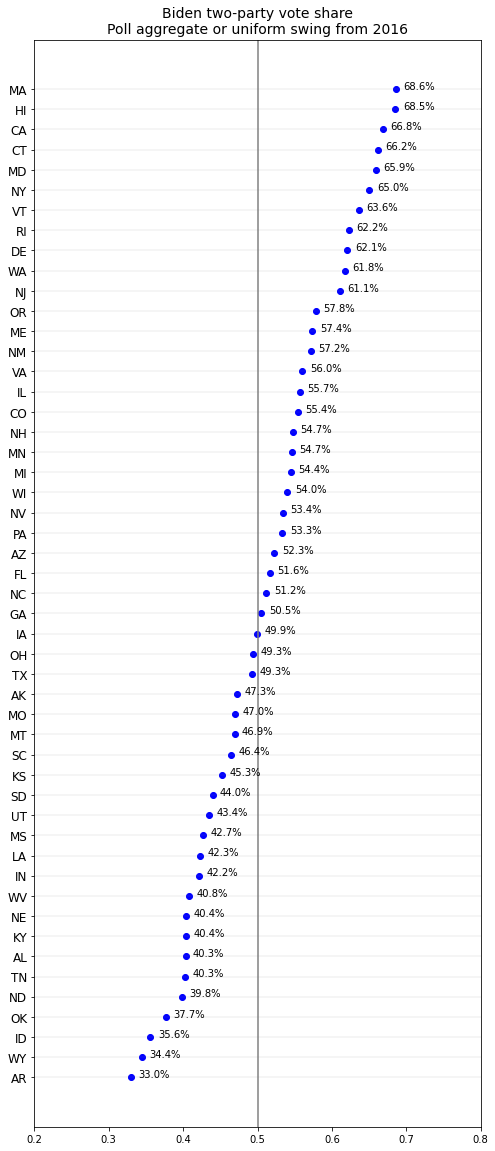

In [15]:
figsize(8,20)

# Don't plot DC
state_mean_sorted = (state_mean.sort_values('biden20_filled'))[:-1]

plt.xlim(0.2,0.8)
plt.title('Biden two-party vote share\nPoll aggregate or uniform swing from 2016', fontsize = 14)
plt.yticks(arange(50), state_mean_sorted.index, fontsize = 12)
axvline(0.5, color = 'gray');

plt.scatter(state_mean_sorted.biden20_filled, arange(50), color = 'blue');
for i, state in enumerate(state_mean_sorted.index):
    axhline(i, color = 'gray', alpha = 0.1);
    text(state_mean_sorted.biden20_filled[state] + 0.01, i, 
         '%s%%'%(100*state_mean_sorted.biden20_filled[state]).round(1));

## Simulate election outcome

Increasing the amount of uncertainty in the state poll average and/or the national polling error shifts the probability of winning towards 0.5.

In [16]:
electoral_votes = DataFrame.from_dict({'AL': 9, 'AK': 3, 'AZ': 11, 'AR': 6, 'CA': 55, 'CO': 9,
                                       'CT': 7, 'DE': 3, 'FL': 29, 'GA': 16, 'HI': 4, 'ID': 4,
                                       'IL': 20, 'IN': 11, 'IA': 6, 'KS': 6, 'KY': 8, 'LA': 8,
                                       'ME': 4, 'MD': 10, 'MA': 11, 'MI': 16, 'MN': 10, 'MS': 6,
                                       'MO': 10, 'MT': 3, 'NE': 5, 'NV': 6, 'NH': 4, 'NJ': 14,
                                       'NM': 5, 'NY': 29, 'NC': 15, 'ND': 3, 'OH': 18, 'OK': 7,
                                       'OR': 7, 'PA': 20, 'RI': 4, 'SC': 9, 'SD': 3, 'TN': 11,
                                       'TX': 38, 'UT': 6, 'VT': 3, 'VA': 13, 'WA': 12, 'WV': 5,
                                       'WI': 10, 'WY': 3, 'DC': 3},
                                      orient='index', columns = ['EV'])

In [17]:
# Simulation settings
number_of_simulations = 10000

# Uncertainty in state forecasts, around poll average
state_uncertainty_sd = 0.05

# Uncertainty in national forecasts; correlated error with mean zero
national_uncertainty_sd = 0.03

In [18]:
#
#
#
#
#
biden_state_wins = Series(0, index = state_mean.index)
biden_state_votes = DataFrame()
biden_ev_sim = []

#for sim in arange(number_of_simulations):
#    # simulate 51 state-level election outcomes
#    national_error = np.random.normal(0, national_uncertainty_sd)
#    one_simulation = DataFrame({'state': state_mean.index,
#                                'biden_vote': np.random.normal(state_mean.biden20_filled, state_uncertainty_sd) +
#                                              national_error}).set_index('state')

for sim in arange(number_of_simulations):
    # simulate 51 state-level election outcomes
    national_error = np.random.normal(0, national_uncertainty_sd)
    biden_vote = {}
    for state, row in state_mean.iterrows():
        biden_vote[state] =  np.random.normal(row['biden20_filled'], zscore["Adjusted Z-Score"][state]*state_uncertainty_sd) + national_error
    one_simulation = DataFrame({'state': state_mean.index}).set_index('state')
    s = pd.Series(biden_vote)
    one_simulation = one_simulation.assign(biden_vote = s.values)
    
    # did Biden win each state in this simulation?
    one_simulation['biden_win'] = (one_simulation.biden_vote > 0.5)+0
    
    # record simulation results
    one_simulation = one_simulation.merge(electoral_votes, left_index = True, right_index = True)
#    print(one_simulation)
    biden_state_wins = biden_state_wins + one_simulation.biden_win
#    print(biden_state_wins)
    biden_state_votes = biden_state_votes.append(one_simulation.biden_vote)
#    print(biden_state_votes)
    biden_ev_sim = biden_ev_sim + [(one_simulation.biden_win * one_simulation.EV).sum()]
#    print(biden_ev_sim)


In [19]:
#print(biden_state_votes)
#print(biden_ev_sim)

## Visualize simulation results and chance of winning each state and nationally

- Black line: The result needed to win
- Red line: Simulation average

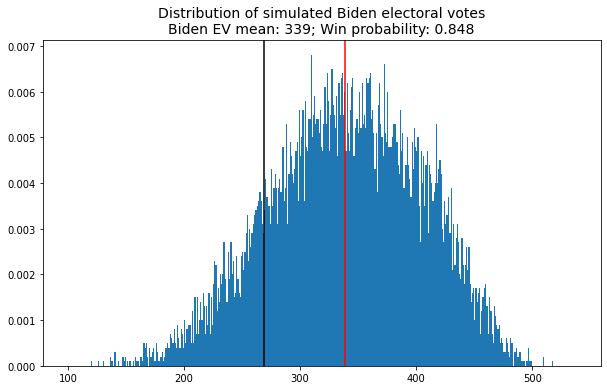

In [20]:
figsize(10,6)
plt.hist(biden_ev_sim, bins = arange(100, 538, 1), density = True);
biden_ev_forecast = int(np.array(biden_ev_sim).mean())
plt.title('Distribution of simulated Biden electoral votes\nBiden EV mean: %s; Win probability: %s'%
          (biden_ev_forecast, (np.array(biden_ev_sim) > 269).mean().round(3)), fontsize = 14);
axvline(269, color = 'black');
axvline(biden_ev_forecast, color = 'red');

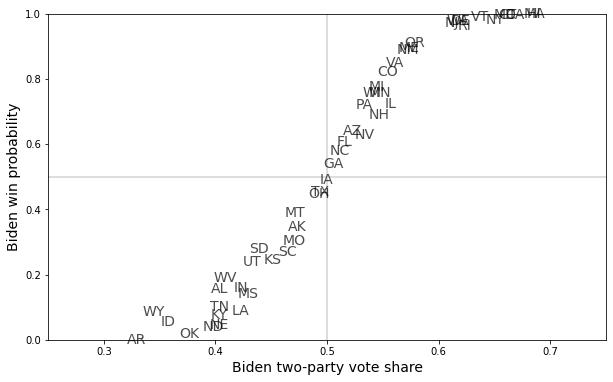

In [21]:
figsize(10,6)
plt.xlim(0.25, 0.75)
plt.xlabel('Biden two-party vote share', fontsize = 14)
plt.ylabel('Biden win probability', fontsize = 14)

biden_state_win_prob = biden_state_wins / number_of_simulations
for state in state_mean.index:
    if state != 'DC':
        plt.text(biden_state_votes.mean()[state],
                 biden_state_win_prob[state],
                 state, ha = 'center', va = 'center', 
                 fontsize = 14, alpha = 0.7)
        
axvline(0.5, color = 'lightgray');
axhline(0.5, color = 'lightgray');

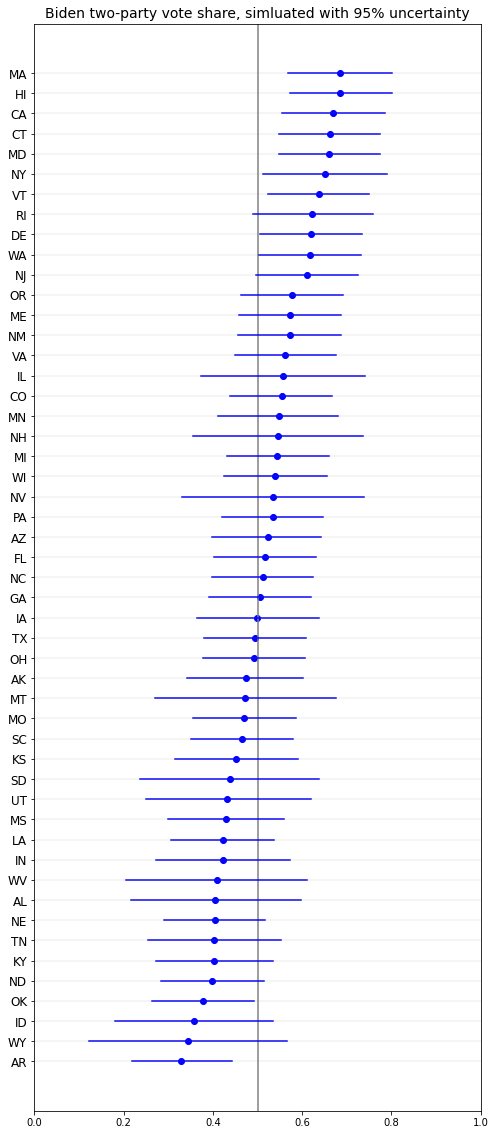

In [22]:
figsize(8,20)

biden_state_votes_sorted = biden_state_votes.mean().sort_values()[:-1]

plt.xlim(0,1)
plt.title('Biden two-party vote share, simluated with 95% uncertainty', fontsize = 14)
plt.yticks(arange(50), biden_state_votes_sorted.index, fontsize = 12)
axvline(0.5, color = 'gray');

plt.scatter(biden_state_votes_sorted, arange(50), color = 'blue');
for i, state in enumerate(biden_state_votes_sorted.index):
    plt.plot([biden_state_votes[state].quantile(0.025), 
              biden_state_votes[state].quantile(0.975)],
              [i, i], color = 'blue');
    axhline(i, color = 'gray', alpha = 0.1);

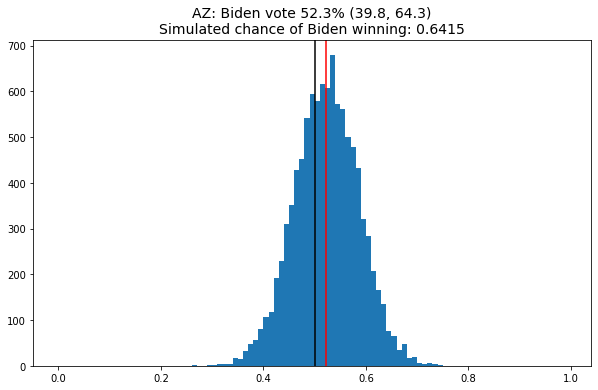

In [23]:
plot_state = 'AZ'

figsize(10,6)
plt.hist(biden_state_votes[plot_state], bins = arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(plot_state,
                                                   np.round((100*biden_state_votes[plot_state].mean()),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
                                                   biden_state_win_prob[plot_state]),
          fontsize = 14)
axvline(0.5, color = 'black');
axvline(biden_state_votes[plot_state].mean(), color = 'red');